In [37]:
%matplotlib inline

from collections import defaultdict

import numpy as np
import pandas as pd

from bokeh.plotting import figure,show,output_notebook
from bokeh.charts import Bar
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.cross_validation import cross_val_score

from sklearn.decomposition import PCA
from sklearn import grid_search

import xgboost as xgb

pd.set_option('display.float_format', lambda x: '%.3f' % x)
output_notebook()


BokehJS successfully loaded.

# Airbnb New User Bookings

Airbnb is a company that gives users the ability to rent temporary lodging from other users. According to Airbnb's website, the company has over 2 million listings in over 35,000 cities and 190 countries. 

In this analysis I will examine data gathered on Airbnb users in order to predict the country of their first booking. All users in this dataset are based in the US. 

# The Data

The datasets contains tables on users, web session data, user demographics, and country information. My analysis will focus on the User data and web session data.

# 1. Load and clean data

In [2]:
# load data

sessions = pd.read_csv('Data/sessions.csv')
train_users = pd.read_csv('Data/train_users_2.csv')
test_users = pd.read_csv('Data/test_users.csv')

train_users.set_index('id',inplace=True,drop=True)
test_users.set_index('id',inplace=True,drop=True)
train_target = train_users['country_destination']

# preserve indicies of training and test data

train_index = train_users.index
test_index = test_users.index

# concatenate dataframes

all_users = pd.concat([train_users,test_users])
all_users = all_users.drop(['country_destination','date_first_booking'],axis=1)


print "training length:",len(train_users)
print "test length:",len(test_users)
print "total",(len(train_users)+len(test_users))


training length: 213451
test length: 62096
total 275547


## User Data

In [3]:
all_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275547 entries, gxn3p5htnn to 9uqfg8txu3
Data columns (total 13 columns):
affiliate_channel          275547 non-null object
affiliate_provider         275547 non-null object
age                        158681 non-null float64
date_account_created       275547 non-null object
first_affiliate_tracked    269462 non-null object
first_browser              275547 non-null object
first_device_type          275547 non-null object
gender                     275547 non-null object
language                   275547 non-null object
signup_app                 275547 non-null object
signup_flow                275547 non-null int64
signup_method              275547 non-null object
timestamp_first_active     275547 non-null int64
dtypes: float64(1), int64(2), object(10)
memory usage: 29.4+ MB


In [4]:
# convert to datetime

all_users['date_account_created'] = pd.to_datetime(all_users['date_account_created'],errors='raise')
all_users['timestamp_first_active'] = pd.to_datetime(all_users['timestamp_first_active'],format='%Y%m%d%H%M%S',errors='raise')

# convert int categorical column to string

all_users['signup_flow'] = all_users['signup_flow'].astype(str)

# separate columns by data type

dtypes_dict = all_users.columns.to_series().groupby(all_users.dtypes).groups
d = {key.name:value for key, value in dtypes_dict.items()}
#d

# separate columns by data type

num_cols = d['float64']
date_cols = d['datetime64[ns]']
cat_cols = d['object']


# Categorical columns

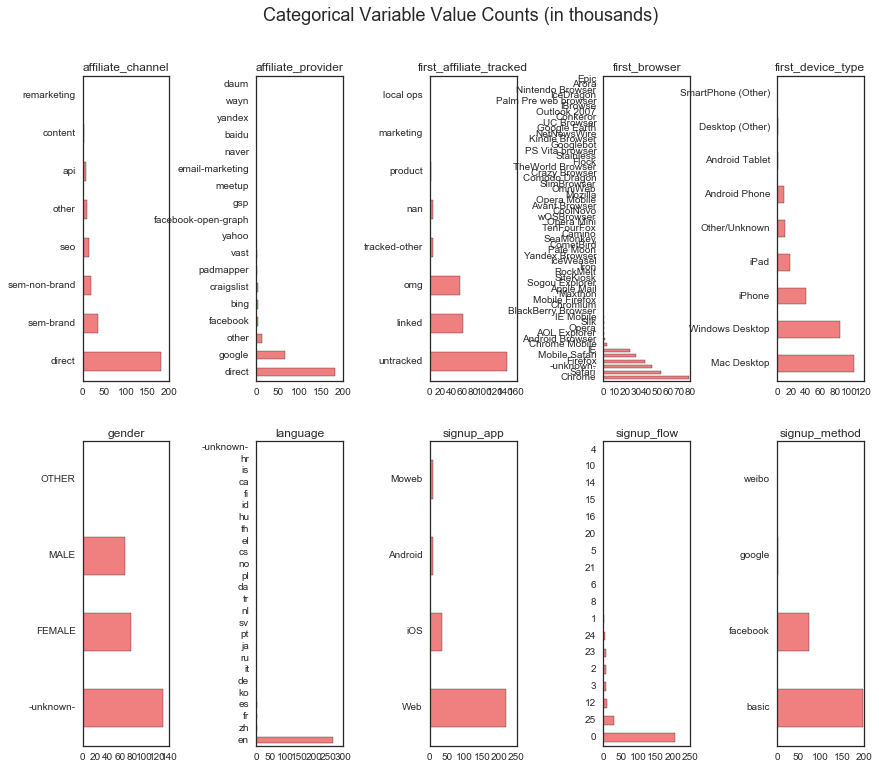

In [5]:
# plot histograms to identify incorrect values

sns.set_style('white')

f,a = plt.subplots(2,5,figsize=(14,12)) # 9X9 and plot first browser separately?
f.suptitle('Categorical Variable Value Counts (in thousands)',fontsize=18)
f.subplots_adjust(wspace=1)
a = a.ravel()

for i,ax in enumerate(a):
    (all_users[cat_cols[i]].value_counts(dropna=False)/1000).plot(kind='barh',color='lightcoral',ax=ax)
    ax.set_title(cat_cols[i])

We have missing values in gender, language, first_affiliate_tracked and first_browser. Gender and first_browser both have a large amount of missing values, so we will not replace them for now.

In [6]:
# Gender

# make text easier to read

all_users.loc[:,'gender'] = all_users['gender'].map(lambda x: x.title())

def convert_gender(val):
    if val not in ['Male','Female']:
        return 'Unknown'
    return val

all_users.loc[:,'gender'] = all_users.gender.apply(convert_gender)

# convert missing values to np.nan

all_users.loc[all_users['language']=='-unknown-','language'] = np.nan

# find all columns that contain missing values

nan_cols = list(all_users.columns[all_users.isnull().any()])
nan_cols.remove('age')

# map nan's to mode

def nan_to_mode(df,col):
    mode = df[col].mode()[0]
    
    df.loc[df[col].isnull(),col] = mode
    
for col in nan_cols:
    nan_to_mode(all_users,col)

print 'Columns with NaN\'s',all_users.columns[all_users.isnull().any()]

Columns with NaN's Index([u'age'], dtype='object')


# Numerical Columns

#### Age

In [7]:
#top10age = all_users.age.value_counts(dropna=False,ascending=True).tail(10)
#top10age.plot(kind='barh',color='lightcoral',title='Top 10 Age Values',ax=axs[0])

#fig, axs = plt.subplots(1,2,figsize=(12,4))

#all_users.age.plot(kind='hist',bins=50,color='lightcoral',ax=axs[1],title='Histogram of User Age')

print 'NaN age values:',len(all_users.age[all_users.age.isnull()])

NaN age values: 116866


We have mostly NaN values and a lot of incorrect values. We will impute these missing age values later.

In [8]:
# exclude age>100 and age<18

over100 = all_users.age[all_users['age']>=100]
under18 = all_users.age[all_users['age']<18]
rest = all_users.age[(all_users['age']<100) & (all_users['age']>=18)]

age_outliers = all_users.age[(all_users['age']>=100) | (all_users['age']<18)]

print 'Number of users over the age of one hundred:',over100.count()
print 'Number of users less than the age of eighteen:',under18.count()


Number of users over the age of one hundred: 2721
Number of users less than the age of eighteen: 188


In [9]:
# mark outliers as missing

all_users.loc[age_outliers.index,'age'] = np.nan

# impute missing age values from categorical columns

labels = defaultdict(LabelEncoder)

X_age_imputed = all_users[cat_cols]
X_age_imputed = X_age_imputed.apply(lambda x: labels[x.name].fit_transform(x))

# split test and train and get target

X_train_age_imputed = X_age_imputed[~all_users['age'].isnull()]
X_test_age_imputed = X_age_imputed[all_users['age'].isnull()]

y_train_age_imputed = all_users['age'][~all_users['age'].isnull()]

# impute values with xgboost

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train_age_imputed.values,y_train_age_imputed.values)

imputed_age = xgb_reg.predict(X_test_age_imputed)

predicted_age = pd.Series(imputed_age, index=X_test_age_imputed.index)
predicted_age.head() # plot feature importances?

# map predicted values to NaN's

all_users.loc[all_users['age'].isnull(),'age'] = predicted_age


NaN age values: 0


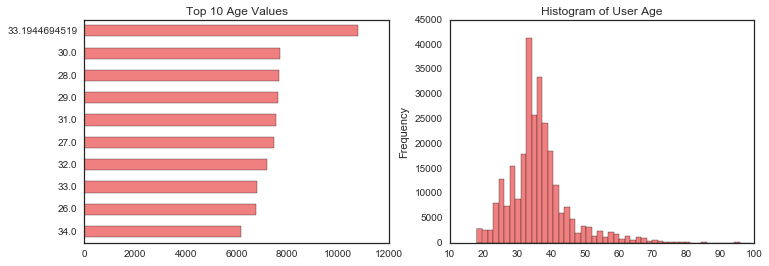

In [10]:
sns.set_style('white')

fig, axs = plt.subplots(1,2,figsize=(12,4))

top10age = all_users.age.value_counts(dropna=False,ascending=True).tail(10)
top10age.plot(kind='barh',color='lightcoral',title='Top 10 Age Values',ax=axs[0])

all_users.age.plot(kind='hist',bins=50,color='lightcoral',ax=axs[1],title='Histogram of User Age')

print 'NaN age values:',len(all_users.age[all_users.age.isnull()])

In [11]:
# date extraction: date_account_created and timestamp_first_active

all_users['tfa_month'] = all_users['timestamp_first_active'].dt.month
all_users['tfa_day'] = all_users['timestamp_first_active'].dt.day
all_users['tfa_dayofweek'] = all_users['timestamp_first_active'].dt.dayofweek

all_users['dac_month'] = all_users['date_account_created'].dt.month
all_users['dac_day'] = all_users['date_account_created'].dt.day
all_users['dac_dayofweek'] = all_users['date_account_created'].dt.dayofweek

date_cols = ['tfa_month','tfa_day','tfa_dayofweek','dac_month','dac_day','dac_dayofweek']


In [12]:
train_clean = all_users.loc[train_index]
train_clean = train_clean.join(train_target)

test_clean = all_users.loc[test_index]


# Web Session Data

In [13]:
sessions.head(2)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.000
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.000


In [14]:
# separate columns by data type

session_dtypes = sessions.columns.to_series().groupby(sessions.dtypes).groups
d = {key.name:value for key, value in session_dtypes.items()}

session_num_cols = d['float64']
session_cat_cols = d['object']


# set unknown values as NaN

for col in session_cat_cols:
    sessions.loc[sessions[col]=='-unknown-',col] = np.nan

# drop all NaN values and set index as user_id

sessions.dropna(axis=0, how='any',inplace=True)


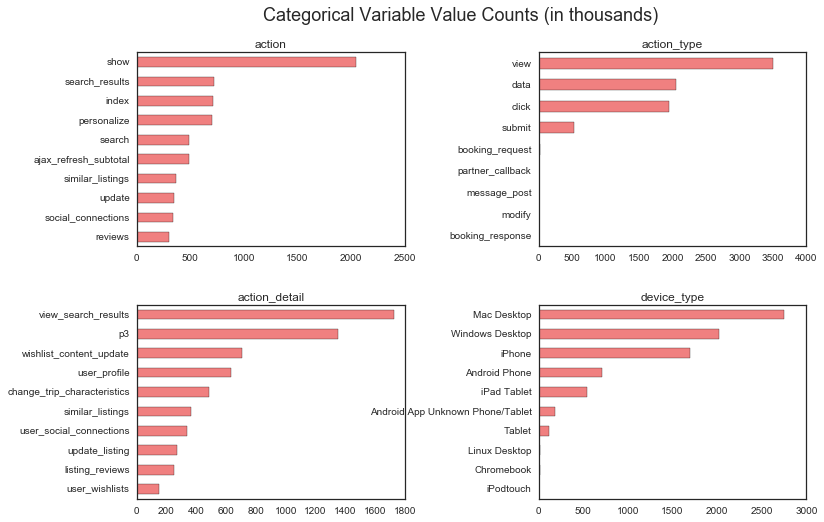

In [15]:
# histograms of categorical columns

sns.set_style('white')
session_cat_cols.remove('user_id')

f,a = plt.subplots(2,2,figsize=(12,8))

f.suptitle('Categorical Variable Value Counts (in thousands)',fontsize=18)
f.subplots_adjust(wspace=0.5,hspace=0.3)
a = a.ravel()

for i,ax in enumerate(a):
    top10vc = sessions[session_cat_cols[i]].value_counts(dropna=False,ascending=True).tail(10)/1000
    top10vc.plot(kind='barh',color='lightcoral',ax=ax)
    ax.set_title(session_cat_cols[i])


# 2. Data Exploration

In [16]:
all_users.head(2)

,affiliate_channel,affiliate_provider,age,date_account_created,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,timestamp_first_active,tfa_month,tfa_day,tfa_dayofweek,dac_month,dac_day,dac_dayofweek
id,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,direct,direct,33.348,2010-06-28,untracked,Chrome,Mac Desktop,Unknown,en,Web,0,facebook,2009-03-19 04:32:55,3,19,3,6,28,0
820tgsjxq7,seo,google,38.000,2011-05-25,untracked,Chrome,Mac Desktop,Male,en,Web,0,facebook,2009-05-23 17:48:09,5,23,5,5,25,2


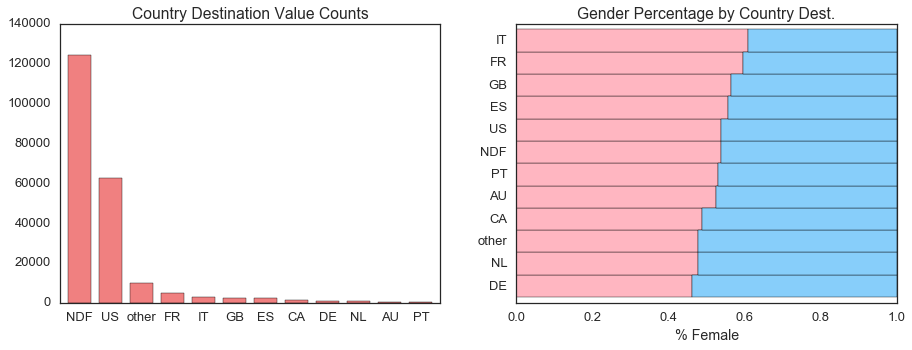

In [17]:
# target value counts

sns.set_style("white")
sns.set_context("talk")

fig, axs = plt.subplots(1,2,figsize=(15,5))

country_vc = train_clean.country_destination.value_counts()
country_vc.plot(kind='bar',rot=0,width=0.75,color='lightcoral',title='Country Destination Value Counts',ax=axs[0])


# plot countries by gender percentage

df = train_clean[['gender','country_destination']][train_clean.gender != 'Unknown']

pt = pd.pivot_table(df,index='country_destination',columns='gender',aggfunc=len,margins=True)

pt = pt.div(pt["All"], axis=0)
pt.drop('All',axis=1,inplace=True)
pt.drop('All',axis=0,inplace=True)

pt.sort_values('Female',inplace=True)

pt.plot(title='Gender Percentage by Country Dest.',kind='barh',stacked=True,
        width=1,legend=False,color=['lightpink','lightskyblue'],ax=axs[1])

axs[1].set_ylabel('')
axs[1].set_xlabel('% Female')

## User Data

In [18]:
for col in cat_cols:
    print col,train_clean[col].nunique()

affiliate_channel 8
affiliate_provider 18
first_affiliate_tracked 7
first_browser 52
first_device_type 9
gender 3
language 25
signup_app 4
signup_flow 17
signup_method 3


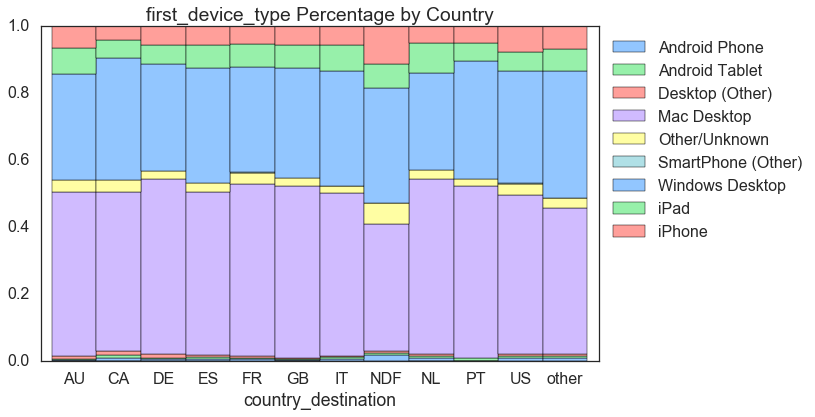

In [19]:
# language, signup_app, signup_method, first_device_type

def target_plot(col):
    df = train_clean[['country_destination',col]]
    pt = pd.pivot_table(df,index='country_destination',
                        columns=col,
                        aggfunc=len,margins=True,
                        fill_value=0)
    
    pt = pt.div(pt["All"], axis=0)

    pt.drop('All',axis=1,inplace=True)
    pt.drop('All',axis=0,inplace=True)
    
    sns.set_style('white')
    sns.set_context('poster')
    
    plt.style.use('seaborn-pastel')
    
    pt.plot(title='{} Percentage by Country'.format(col),
            kind='bar',
            ylim=(0,1),
            stacked=True,
            width=1,
            figsize=(10,6),
            rot=0,
            legend='reversed')
    
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))


target_plot('first_device_type')
#target_plot('signup_method')

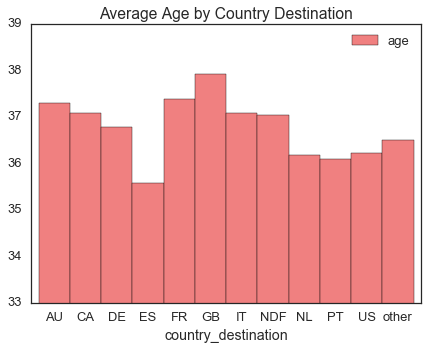

In [20]:
sns.set_style('white')
sns.set_context('talk')


df = train_clean[['country_destination','age']]

age_by_country = df.groupby('country_destination').mean()

age_by_country.plot(kind='bar',
                    title='Average Age by Country Destination',
                    color='lightcoral',figsize=(7,5),
                    rot=0,
                    width=1,
                    ylim=(33,39))


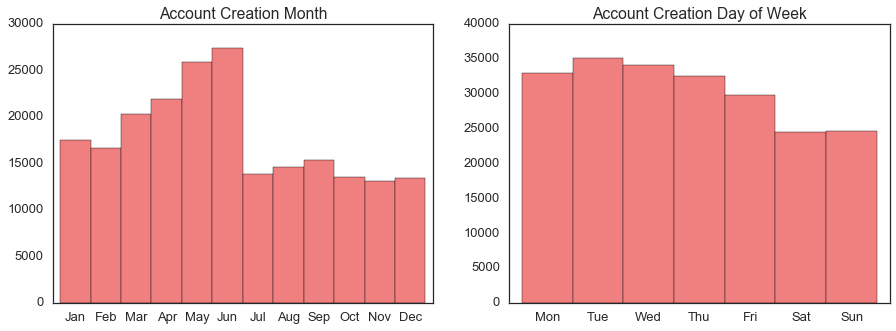

In [21]:
import calendar

fig, axs = plt.subplots(1,2,figsize=(15,5))

dac_month_vc = train_clean['dac_month'].value_counts().sort_index()
dac_dow_vc = train_clean['dac_dayofweek'].value_counts().sort_index()

dac_month_vc.plot(kind='bar',rot=0,ax=axs[0],color='lightcoral',width=1,title='Account Creation Month')
axs[0].set_xticklabels(list(calendar.month_abbr)[1:], rotation=0)

dac_dow_vc.plot(kind='bar',rot=0,ax=axs[1],color='lightcoral',width=1,title='Account Creation Day of Week')
axs[1].set_xticklabels(list(calendar.day_abbr), rotation=0)

plt.show()

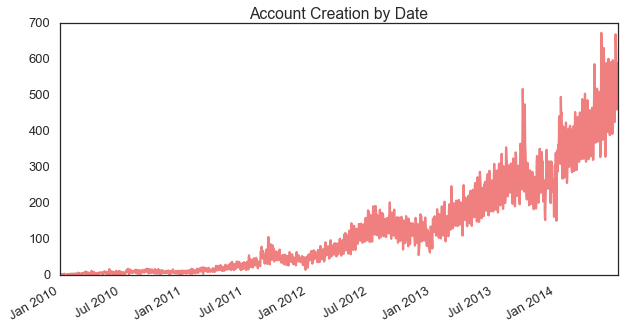

In [22]:
dac_vc = train_clean['date_account_created'].value_counts()

ax = dac_vc.plot(kind='line',color='lightcoral',figsize=(10,5),title='Account Creation by Date')

# Web Session Data

In [23]:
sessions_train = sessions[sessions.user_id.isin(train_clean.index.unique())]
sessions_test = sessions[sessions.user_id.isin(test_clean.index.unique())]

In [24]:
sessions_train.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.000
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.000
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.000
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.000
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.000


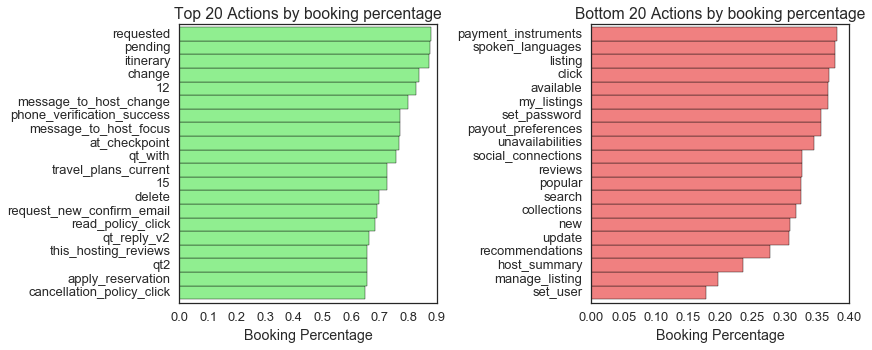

In [25]:
# plot actions that have highest percentages of booking

sns.set_style('white')
sns.set_context('talk')

def is_booking(x):
    if x == 'NDF':
        return 0 
    else:
        return 1

booked = train_clean['country_destination'].apply(is_booking)

actions_bookings = sessions_train.join(booked,on='user_id').groupby('action').filter(lambda x: len(x) > 200)
actions_bookings = actions_bookings.groupby('action').mean()
actions_bookings.sort_values('country_destination',inplace=True)

# plot actions by booking percentage

fig, axs = plt.subplots(1,2,figsize=(12,5))

top_actions = actions_bookings['country_destination'].tail(20)
bottom_actions = actions_bookings['country_destination'].head(20)

fig.subplots_adjust(wspace=0.6)

top_actions.plot(kind='barh',ax=axs[0],width=1,title='Top 20 Actions by booking percentage',color='lightgreen')
bottom_actions.plot(kind='barh',ax=axs[1],width=1,title='Bottom 20 Actions by booking percentage',color='lightcoral')

axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[0].set_xlabel('Booking Percentage')
axs[1].set_xlabel('Booking Percentage')

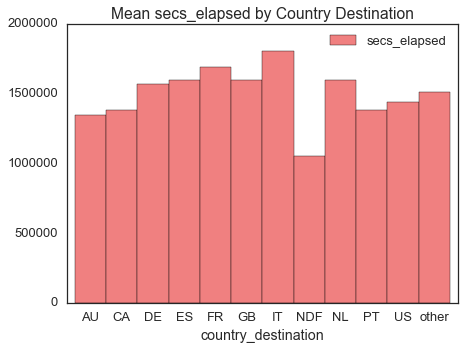

In [26]:
# average secs_elapsed by Country Destination

sns.set_style('white')
sns.set_context('talk')

sum_by_id = sessions_train.groupby('user_id').sum()
sum_by_id = sum_by_id.join(train_clean['country_destination'])

mean_se = sum_by_id.groupby('country_destination').mean()
mean_se.plot(kind='bar',width=1,rot=0,figsize=(7,5),title='Mean secs_elapsed by Country Destination',color='lightcoral')


# 3. Feature Extraction

In [27]:
sessions.head(5)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.000
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.000
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.000
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.000
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.000


In [28]:
pv = sessions.pivot_table(index=['user_id'],
                                values='secs_elapsed',
                                columns=['action_detail','action_type'],
                                aggfunc=[len, np.sum],
                                fill_value=0)

ind = [' '.join(col).strip() for col in pv.columns.values]
pv.columns=ind

print np.shape(pv)
pv.head(2)


(130658, 314)


,len account_notification_settings view,len account_payment_methods view,len account_payout_preferences view,len account_privacy_settings view,len account_transaction_history view,len admin_templates data,len airbnb_picks_wishlists view,len alteration_field click,len alteration_request view,len apply_coupon submit,...,sum view_search_results click,sum view_search_results view,sum view_security_checks view,sum view_user_real_names view,sum wishlist view,sum wishlist_content_update data,sum wishlist_note submit,sum your_listings view,sum your_reservations view,sum your_trips view
user_id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,0,0,0,0,0,0,0,0,0,0,...,22079,32712,0,0,0,3515,0,0,0,1466
0010k6l0om,0,0,0,0,0,0,0,0,0,0,...,45844,30107,0,0,0,135661,0,0,0,0


In [29]:
dropcols = ['date_account_created','timestamp_first_active']

# encode categorical columns

labels = defaultdict(LabelEncoder)

X_cat = all_users[cat_cols]
X_cat = X_cat.apply(lambda x: labels[x.name].fit_transform(x))

# join date columns

X_cat = X_cat.join(all_users[date_cols])

In [30]:
# scale numerical user data columns

scaler = StandardScaler()

X_age = all_users['age']
X_age = pd.Series(scaler.fit_transform(X_age), name = 'Age', index=X_age.index)

X_users = X_cat.join(X_age)

# scale session pivot table

X_session = pd.DataFrame(scaler.fit_transform(pv), columns=pv.columns,index=pv.index)

#X_session.head()

/Applications/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [31]:
# Create X_train_1, X_train_2, and X_test_1 and X_test_2

X_users_train = X_users.loc[train_index]
X_users_test = X_users.loc[test_index]

# encode target

le = LabelEncoder()

target_enc = pd.Series(le.fit_transform(train_target),name='country_destination',index=train_target.index)

# Model 1: User and Web Session data

X_train_m1 = X_users_train.join(X_session,how='inner')
X_test_m1 = X_users_test.join(X_session,how='inner')

target_m1 = target_enc[target_enc.index.isin(X_train_m1.index)]

# Model 2: User data only

X_train_m2 = X_users_train[~X_users_train.index.isin(X_train_m1.index)]
X_test_m2 = X_users_test[~X_users_test.index.isin(X_test_m1.index)]

target_m2 = target_enc[target_enc.index.isin(X_train_m2.index)]


# 4. Model Building

# Model 1 - User and Web Session Data

In [32]:
xbg1 = xgb.XGBClassifier(max_depth=6,
                         n_estimators=100,
                         objective='multi:softprob',
                         colsample_bytree=0.4)


xbg1.fit(X_train_m1.values,target_m1.values)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

# Model 2 - User data only

In [33]:
xbg2 = xgb.XGBClassifier(max_depth=7,
                         n_estimators=100,
                         objective='multi:softprob',
                         colsample_bytree=0.5)


xbg2.fit(X_train_m2.values,target_m2.values)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

# 5. Submission

In [34]:
probs1 = xbg1.predict_proba(X_test_m1)

ids = []
c_list = []

for i in range(len(X_test_m1.index)):
    ids.extend([X_test_m1.index[i]] * 5)
    c_list += le.inverse_transform(np.argsort(probs1[i])[::-1])[:5].tolist()

submission_m1 = pd.DataFrame({'country':c_list,'id':ids,},columns=['id','country'])

#submission_m1.head(10)

In [35]:
probs2 = xbg2.predict_proba(X_test_m2.values)

ids2 = []
c_list2 = []

for i in range(len(X_test_m2.index)):
    ids2.extend([X_test_m2.index[i]] * 5)
    c_list2 += le.inverse_transform(np.argsort(probs2[i])[::-1])[:5].tolist()
    
submission_m2 = pd.DataFrame({'country':c_list2,'id':ids2,},columns=['id','country'])

#submission_m2.head(10)


In [36]:
submission = submission_m1.append(submission_m2,ignore_index=False)

submission.to_csv('submission10.csv',index=0)